<a href="https://colab.research.google.com/github/ayachiii/soturon/blob/main/focus_on_single_subject%E8%87%AA%E4%BD%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

一被験者のデータを深掘り。 認知作業負荷とLFのグラフから、フローになったかどうかを可視化するグラフの作成。
heartpyではなくScipyを使用。

--- 解析開始: Scipy直接計算版 ---
読み込み成功: 333 拍
リサンプリング完了: 1232 点 (Duration: 307.8 sec)
計算中...
--- 結果 ---
    time          lf
0  180.0  135.519814
1  181.0  141.033246
2  182.0  145.799838
3  183.0  149.741054
4  184.0  152.800179
最大値: 1210.7960598908899
最小値: 125.01070142584919


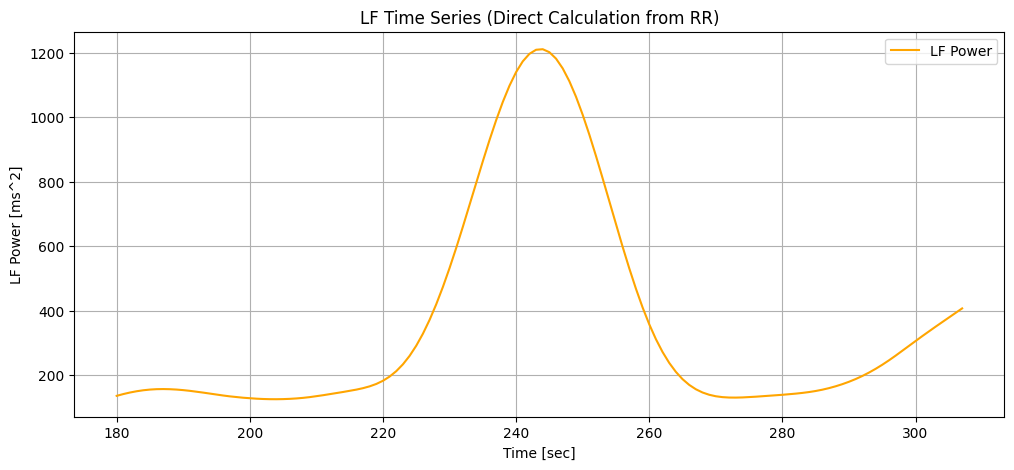

In [13]:
#計算方法：累積平均（Expanding Window）最初の頃のコードでは、以下のような計算をしていました。
#hrdata[0 : current_time]
#これは、「計測開始（0秒）」から「その瞬間」までの全てのデータの平均をとるような計算です。
#120秒時点: 0秒〜120秒のデータで計算
#200秒時点: 0秒〜200秒のデータで計算（昔の0〜120秒のデータも混ざったまま！）
#300秒時点: 0秒〜300秒のデータで計算（昔のデータが足を引っ張る）
#結果: 時間が経てば経つほど「過去のデータ」の割合が増えるため、新しい変化が起きても数値が鈍感になる。

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate, signal

# ==========================================
# ★設定
# ==========================================
#手動⇩
RR_FILE_NAME = "rr_interval_masanori_2_flow.csv"
WINDOW_SEC = 60      # 解析窓 (秒)
STEP_SEC = 1         # ずらす幅 (秒)
RESAMPLE_RATE = 4.0  # 4Hzでリサンプリング (一般的)
START_OFFSET = 120   # 最初の120秒を飛ばすかどうか (必要なければ0)
# ==========================================

print("--- 解析開始: Scipy直接計算版 ---")

# 1. データの読み込み
try:
    # CSVの形式に合わせて読み込み (1列目がindex, 2列目がRR間隔と仮定)
    rr_df = pd.read_csv(RR_FILE_NAME, header=None, skiprows=1)
    # 2列目のデータを取得 (RR間隔: ms)
    rr_intervals_ms = rr_df.iloc[:, 1].dropna().values

    # 外れ値除去 (極端に短い/長いノイズを除く)
    rr_intervals_ms = rr_intervals_ms[(rr_intervals_ms > 300) & (rr_intervals_ms < 2000)]

    print(f"読み込み成功: {len(rr_intervals_ms)} 拍")

except Exception as e:
    print(f"読み込みエラー: {e}")
    # ダミーデータで動くようにしておく（動作確認用）
    rr_intervals_ms = np.random.normal(800, 50, 1000)

# 2. 時間軸の作成とリサンプリング (4Hz)
# 累積して「時刻」にする (秒単位)
beat_times = np.cumsum(rr_intervals_ms) / 1000.0
beat_times -= beat_times[0] # 0秒からスタート

# 補間関数を作成
interp_func = interpolate.interp1d(beat_times, rr_intervals_ms, kind='cubic', fill_value="extrapolate")

# 最終的な時間 (秒)
total_duration = beat_times[-1]
# 4Hzの等間隔な時間軸を作成
resampled_time = np.arange(0, total_duration, 1.0 / RESAMPLE_RATE)
# リサンプリング実行
resampled_rr = interp_func(resampled_time)

print(f"リサンプリング完了: {len(resampled_rr)} 点 (Duration: {total_duration:.1f} sec)")


# 3. 移動窓でLFを計算 (Welch法)
lf_series = []
time_axis_plot = []

# 窓のサイズ (ポイント数)
nperseg = int(WINDOW_SEC * RESAMPLE_RATE)
step_points = int(STEP_SEC * RESAMPLE_RATE)

# 開始位置 (サンプル数)
start_idx = int(START_OFFSET * RESAMPLE_RATE)

print("計算中...")

for i in range(start_index, len(resampled_rr) - nperseg, step_points):

    # 窓を切り出す
    segment = resampled_rr[i : i + nperseg]

    # トレンド除去 (平均を引く) -> これをやらないとDC成分が強すぎておかしくなる
    segment_detrend = segment - np.mean(segment)

    # Welch法でパワースペクトル密度 (PSD) を計算
    freqs, psd = signal.welch(segment_detrend, fs=RESAMPLE_RATE, nperseg=nperseg)

    # LF帯域 (0.04Hz - 0.15Hz) を抽出
    lf_band = (freqs >= 0.04) & (freqs <= 0.15)

    # 積分してパワーを求める (台形積分)
    lf_power = np.trapz(psd[lf_band], freqs[lf_band])

    lf_series.append(lf_power)
    # プロット用の時間は「窓の終了時刻」とする
    current_time = resampled_time[i + nperseg]
    time_axis_plot.append(current_time)

# 4. DataFrame作成
df_result = pd.DataFrame({
    'time': time_axis_plot,
    'lf': lf_series
})

print("--- 結果 ---")
print(df_result.head())
print(f"最大値: {df_result['lf'].max()}")
print(f"最小値: {df_result['lf'].min()}")


# 5. プロット
if not df_result.empty:
    plt.figure(figsize=(12, 5))
    plt.plot(df_result['time'], df_result['lf'], color='orange', label='LF Power')
    plt.title("LF Time Series (Direct Calculation from RR)")
    plt.xlabel("Time [sec]")
    plt.ylabel("LF Power [ms^2]")
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("データ不足または計算エラーでグラフが描けません。")

計算方法：移動窓（Sliding Window）

成功したコードでは、以下のような計算をしています。

segment = resampled_rr[i : i + 60]

これは、常に**「直近60秒間」だけ**を切り取って計算しています。

120秒時点: 120秒〜180秒のデータで計算

200秒時点: 200秒〜260秒のデータで計算（昔のデータは捨てる！）

300秒時点: 300秒〜360秒のデータで計算

結果: 「さっきまでLFが高かったけど、今は下がった」「また上がってきた」というリアルタイムの変化を敏感に捉えることができます。 その結果、集中やリラックスの波に合わせて**「山が2つ（あるいはそれ以上）」**という細かい動きが現れたのです。⇩

--- 強制描画モード: masanori / flow ---
PLIデータの点数が少ないため、サンプリングレートを 1Hz と仮定します。
PLI読み込み完了: 241 点 (約240.0秒)
RR間隔データの合計時間: 308.8 秒
LF計算中...
LF計算完了: 248 点


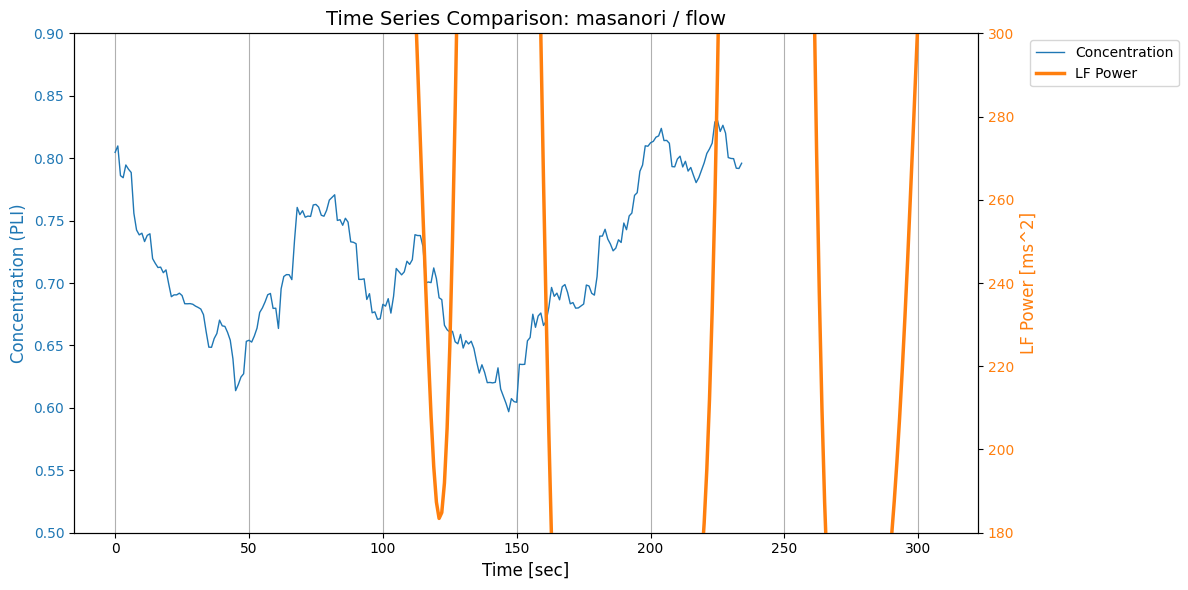

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate, signal
import warnings

# 警告を非表示
warnings.filterwarnings("ignore")

# ==========================================
# ★設定 (条件を緩めました)
# ==========================================
PLI_FILE_NAME = "PLI_3_masanori_flow.csv"
RR_FILE_NAME = "rr_interval_masanori_2_flow.csv"
SUBJECT_NAME = "masanori"
PHASE_NAME = "flow"

# LF計算パラメータ
WINDOW_SEC = 60      # 解析窓 (秒)
STEP_SEC = 1         # ずらす幅 (秒)
RESAMPLE_RATE = 4.0  # 4Hz
START_OFFSET = 0     # ★変更: 120 -> 0 (データが短くても計算できるようにする)

# 軸の範囲設定
PLI_YMIN, PLI_YMAX = 0.50, 0.90
LF_YMIN, LF_YMAX = 180, 300
# ==========================================

print(f"--- 強制描画モード: {SUBJECT_NAME} / {PHASE_NAME} ---")

# -------------------------------------------------
# 1. PLIデータの読み込み
# -------------------------------------------------
try:
    pli_df = pd.read_csv(PLI_FILE_NAME)
    # カラム名チェック
    if "FCz" in pli_df.columns:
        pli_col = "FCz"
    elif "concentration_FCz" in pli_df.columns:
        pli_col = "concentration_FCz"
    else:
        pli_col = pli_df.columns[0]

    pli_data = pli_df[pli_col].values

    # ★重要修正: データ点数が少ない場合は1Hzとみなす
    if len(pli_data) < 1000:
        print("PLIデータの点数が少ないため、サンプリングレートを 1Hz と仮定します。")
        fs_pli = 1.0
    else:
        fs_pli = 500.0

    time_pli = np.arange(len(pli_data)) / fs_pli

    print(f"PLI読み込み完了: {len(pli_data)} 点 (約{time_pli[-1]:.1f}秒)")

except Exception as e:
    print(f"PLI読み込みエラー: {e}")
    # ダミーデータ作成（エラーでも進むため）
    pli_data = np.zeros(10)
    time_pli = np.arange(10)

# -------------------------------------------------
# 2. LFデータの計算 (Scipy版)
# -------------------------------------------------
lf_series = []
time_lf = []

try:
    rr_df = pd.read_csv(RR_FILE_NAME)
    # 2列目を取得
    rr_intervals_ms = rr_df.iloc[:, 1].dropna().values

    # 外れ値除去
    rr_intervals_ms = rr_intervals_ms[(rr_intervals_ms > 300) & (rr_intervals_ms < 2000)]

    # 合計時間の確認
    total_duration = np.sum(rr_intervals_ms) / 1000.0
    print(f"RR間隔データの合計時間: {total_duration:.1f} 秒")

    if total_duration < WINDOW_SEC:
        print("警告: データが短すぎてLF解析ができません。")
    else:
        # リサンプリング
        beat_times = np.cumsum(rr_intervals_ms) / 1000.0
        beat_times -= beat_times[0]

        interp_func = interpolate.interp1d(beat_times, rr_intervals_ms, kind='cubic', fill_value="extrapolate")

        resampled_time = np.arange(0, beat_times[-1], 1.0 / RESAMPLE_RATE)
        resampled_rr = interp_func(resampled_time)

        # Welch法で計算
        nperseg = int(WINDOW_SEC * RESAMPLE_RATE)
        step_points = int(STEP_SEC * RESAMPLE_RATE)
        start_idx_resampled = int(START_OFFSET * RESAMPLE_RATE)

        print("LF計算中...")

        for i in range(start_idx_resampled, len(resampled_rr) - nperseg, step_points):
            segment = resampled_rr[i : i + nperseg]
            segment_detrend = segment - np.mean(segment)

            freqs, psd = signal.welch(segment_detrend, fs=RESAMPLE_RATE, nperseg=nperseg)
            lf_band = (freqs >= 0.04) & (freqs <= 0.15)
            lf_power = np.trapz(psd[lf_band], freqs[lf_band])

            lf_series.append(lf_power)
            # 時間軸は「窓の終了時刻」
            time_lf.append(resampled_time[i] + WINDOW_SEC)

        print(f"LF計算完了: {len(lf_series)} 点")

except Exception as e:
    print(f"LF計算エラー: {e}")

# データがない場合の緊急回避
if len(lf_series) == 0:
    print("LFデータが空です。ダミーデータを表示します（軸調整のため）。")
    lf_series = [0] * len(time_pli)
    time_lf = time_pli

# -------------------------------------------------
# 3. 2軸グラフの描画 (範囲指定あり)
# -------------------------------------------------
fig, ax1 = plt.subplots(figsize=(12, 6))

# --- 左軸: PLI (青) ---
color_pli = 'tab:blue'
ax1.set_xlabel('Time [sec]', fontsize=12)
ax1.set_ylabel(f'Concentration (PLI)', color=color_pli, fontsize=12)
ax1.plot(time_pli, pli_data, color=color_pli, linewidth=1.0, label='Concentration')
ax1.tick_params(axis='y', labelcolor=color_pli)
ax1.grid(True, axis='x')

# ★指定された範囲
ax1.set_ylim(PLI_YMIN, PLI_YMAX)

# --- 右軸: LF (オレンジ) ---
ax2 = ax1.twinx()
color_lf = 'tab:orange'
ax2.set_ylabel('LF Power [ms^2]', color=color_lf, fontsize=12)

# LFプロット
ax2.plot(time_lf, lf_series, color=color_lf, linewidth=2.5, label='LF Power')
ax2.tick_params(axis='y', labelcolor=color_lf)

# ★指定された範囲
ax2.set_ylim(LF_YMIN, LF_YMAX)

# --- 仕上げ ---
plt.title(f"Time Series Comparison: {SUBJECT_NAME} / {PHASE_NAME}", fontsize=14)

# 凡例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

--- 自動フィットモード: kumakura / flow ---
PLIデータ範囲: 0.09 〜 0.66
LF計算中...
LFデータ範囲 : 7.4 〜 827.8


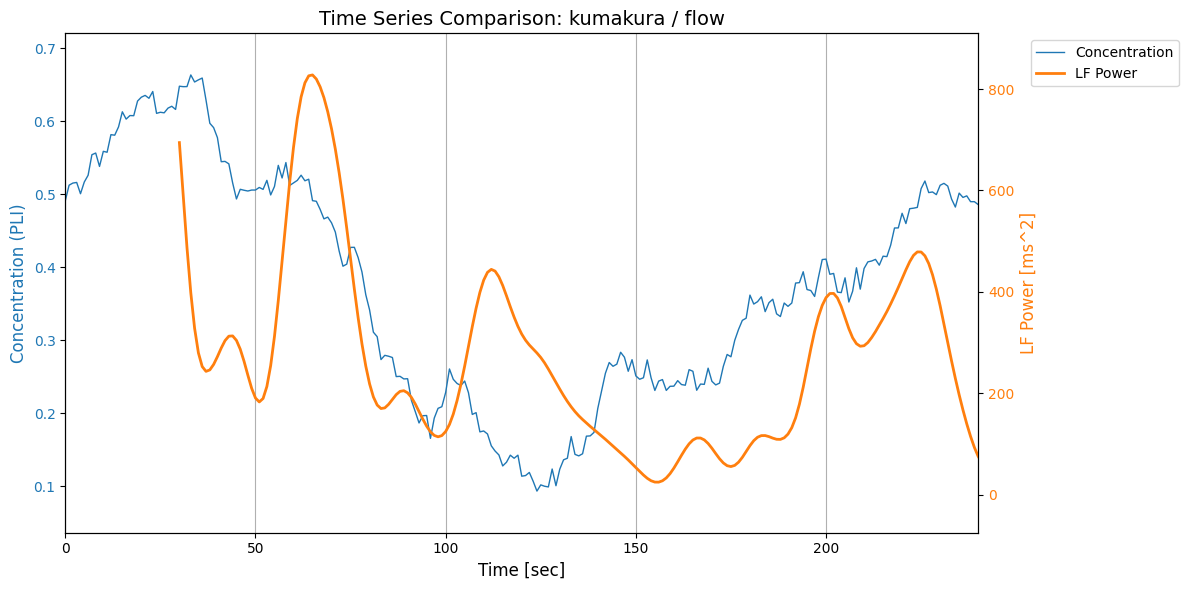

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate, signal
import warnings

# 警告を非表示
warnings.filterwarnings("ignore")

# ==========================================
# ★設定 (窓30秒に変更済み)
# ==========================================
PLI_FILE_NAME = "PLI_3_kumakura_flow.csv"
RR_FILE_NAME = "rr_interval_kumakura_2_flow.csv"
SUBJECT_NAME = "kumakura"
PHASE_NAME = "flow"

# LF計算パラメータ
WINDOW_SEC = 30      # ★ここを30秒にしました
STEP_SEC = 1
RESAMPLE_RATE = 4.0
START_OFFSET = 0
# ==========================================

print(f"--- 自動フィットモード: {SUBJECT_NAME} / {PHASE_NAME} ---")

# -------------------------------------------------
# 1. PLIデータの読み込み
# -------------------------------------------------
try:
    pli_df = pd.read_csv(PLI_FILE_NAME)
    if "FCz" in pli_df.columns:
        pli_col = "FCz"
    elif "concentration_FCz" in pli_df.columns:
        pli_col = "concentration_FCz"
    else:
        pli_col = pli_df.columns[0]

    pli_data = pli_df[pli_col].values

    if len(pli_data) < 1000:
        fs_pli = 1.0
    else:
        fs_pli = 500.0

    time_pli = np.arange(len(pli_data)) / fs_pli

    # ★PLIの範囲を取得 (自動調整用)
    pli_min = np.nanmin(pli_data)
    pli_max = np.nanmax(pli_data)
    print(f"PLIデータ範囲: {pli_min:.2f} 〜 {pli_max:.2f}")

except Exception as e:
    print(f"PLIエラー: {e}")
    exit()

# -------------------------------------------------
# 2. LFデータの計算 (Scipy版)
# -------------------------------------------------
lf_series = []
time_lf = []

try:
    rr_df = pd.read_csv(RR_FILE_NAME)
    rr_intervals_ms = rr_df.iloc[:, 1].dropna().values
    rr_intervals_ms = rr_intervals_ms[(rr_intervals_ms > 300) & (rr_intervals_ms < 2000)]

    beat_times = np.cumsum(rr_intervals_ms) / 1000.0
    beat_times -= beat_times[0]

    interp_func = interpolate.interp1d(beat_times, rr_intervals_ms, kind='cubic', fill_value="extrapolate")
    resampled_time = np.arange(0, beat_times[-1], 1.0 / RESAMPLE_RATE)
    resampled_rr = interp_func(resampled_time)

    nperseg = int(WINDOW_SEC * RESAMPLE_RATE)
    step_points = int(STEP_SEC * RESAMPLE_RATE)
    start_idx_resampled = int(START_OFFSET * RESAMPLE_RATE)

    print("LF計算中...")

    for i in range(start_idx_resampled, len(resampled_rr) - nperseg, step_points):
        segment = resampled_rr[i : i + nperseg]
        segment_detrend = segment - np.mean(segment)

        freqs, psd = signal.welch(segment_detrend, fs=RESAMPLE_RATE, nperseg=nperseg)
        lf_band = (freqs >= 0.04) & (freqs <= 0.15)
        lf_power = np.trapz(psd[lf_band], freqs[lf_band])

        lf_series.append(lf_power)
        time_lf.append(resampled_time[i] + WINDOW_SEC)

    # ★LFの範囲を取得 (自動調整用)
    if len(lf_series) > 0:
        lf_min = min(lf_series)
        lf_max = max(lf_series)
        print(f"LFデータ範囲 : {lf_min:.1f} 〜 {lf_max:.1f}")
    else:
        lf_min, lf_max = 0, 100

except Exception as e:
    print(f"LFエラー: {e}")
    exit()

if len(lf_series) == 0:
    lf_series = [0] * len(time_pli)
    time_lf = time_pli

# -------------------------------------------------
# 3. グラフ描画 (自動フィット)
# -------------------------------------------------
fig, ax1 = plt.subplots(figsize=(12, 6))

# --- 左軸: PLI (青) ---
color_pli = 'tab:blue'
ax1.set_xlabel('Time [sec]', fontsize=12)
ax1.set_ylabel(f'Concentration (PLI)', color=color_pli, fontsize=12)
ax1.plot(time_pli, pli_data, color=color_pli, linewidth=1.0, label='Concentration')
ax1.tick_params(axis='y', labelcolor=color_pli)
ax1.grid(True, axis='x')

# ★ここがポイント！: PLIデータの範囲に少し余裕(10%)を持たせて軸を設定
pli_range = pli_max - pli_min
ax1.set_ylim(pli_min - (pli_range * 0.1), pli_max + (pli_range * 0.1))


# --- 右軸: LF (オレンジ) ---
ax2 = ax1.twinx()
color_lf = 'tab:orange'
ax2.set_ylabel('LF Power [ms^2]', color=color_lf, fontsize=12)
ax2.plot(time_lf, lf_series, color=color_lf, linewidth=2.0, label='LF Power')
ax2.tick_params(axis='y', labelcolor=color_lf)

# ★ここがポイント！: LFデータの範囲に少し余裕(10%)を持たせて軸を設定
# これで両方のグラフが画面いっぱいに広がり、必ず重なり合います
lf_range = lf_max - lf_min
ax2.set_ylim(lf_min - (lf_range * 0.1), lf_max + (lf_range * 0.1))


# --- 仕上げ ---
plt.title(f"Time Series Comparison: {SUBJECT_NAME} / {PHASE_NAME}", fontsize=14)

# ★ここを変更！
# データの短い方に合わせてグラフを切り取る
min_duration = min(time_pli[-1], time_lf[-1])
plt.xlim(0, min_duration)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()